In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import timeit
from models import *

## First look at the data

In [2]:
sample = 'Silver/'
curve = 'Complete/'
PISN_split = '-1'
model = '_poly'

In [25]:
# this cannot be run without the filtered_dataDB_complete.pkl file

data = pd.read_pickle("../../plasticc/CleanDataBase/"+sample+curve+"train"+PISN_split+".pkl")
objects = np.unique(data['object_id'])
target_types = np.hstack([np.unique(data['target']), [999]])
data[(data['object_id']==713)  & (data['passband']==2)]

,object_id,passband,mjd,flux,flux_err,detected_bool,target
0,713,2,0.0000,0.865240,1.013889,0,88
1,713,2,13.9561,0.470419,1.196956,0,88
2,713,2,16.9387,0.614715,1.110572,0,88
3,713,2,28.9489,0.374765,0.922779,0,88
4,713,2,31.9279,0.374007,2.088610,0,88
5,713,2,41.9000,0.131102,1.105223,0,88
6,713,2,44.8921,0.323340,0.889940,0,88
7,713,2,47.8842,0.367542,0.763644,0,88
8,713,2,58.8692,0.293644,0.995209,0,88
9,713,2,61.8351,0.475987,1.668699,0,88


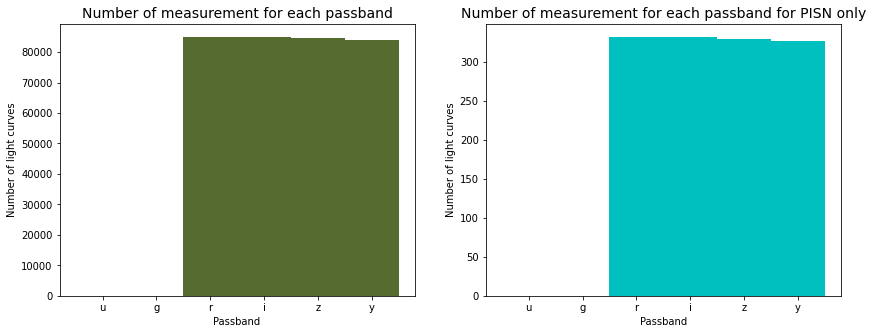

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.title('Number of measurement for each passband',fontsize=14)
plt.hist(data['passband'],bins=[0,1,2,3,4,5,6],color='darkolivegreen')
plt.ylabel('Number of light curves')
plt.xlabel('Passband')
plt.xticks(np.arange(6)+0.5, ['u','g','r','i','z','y']);

plt.subplot(1,2,2)
plt.title('Number of measurement for each passband for PISN only',fontsize=14)
plt.hist(data.loc[data['target']==994,'passband'],bins=[0,1,2,3,4,5,6],color='c')
plt.ylabel('Number of light curves')
plt.xlabel('Passband')
plt.xticks(np.arange(6)+0.5, ['u','g','r','i','z','y']);

## Define useful functions

In [5]:
#Dictionnaire de correspondance des passband et des targets
passband_list = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'}
target_dict={90:'SNIa',67:'SNIa-91bg',
             52:'SNIax',42:'SNII',
             62:'SNIbc',95:'SLSN-I',
             15:'TDE',64:'KN',
             88:'AGN',92:'RRL',
             65:'M-dwarf',16:'EB',
             53:'Mira',6:'Lens-Single',
             994:'PISN', 999:'UNKNOWN'}


In [42]:
def compare(ide,band,table,model,nb_param,extra,band_used):
    
    obj = data.loc[(data['object_id']==ide) & (data['passband']==band)]
    flux = np.array(obj['flux'])
    time = np.array(obj['mjd'])
    fluxerr = np.array(obj['flux_err'])
    obj_target = np.array(data[data['object_id']==ide]['target'])[0]
    
    if len(time)<=nb_param:
        print('Not enough points for object',ide,'in band',band)
        
    else :
        # Let's fit the data as a scatter
        plt.errorbar(time,flux,yerr=fluxerr,label="data band %s"%(band),fmt='o')
        plt.title('Object n°%s : %s'%(ide,target_dict.get(obj_target)))
        plt.xlabel('Time')
        plt.ylabel('Flux')


        #And the prediction
        x = np.linspace(time.min(),time.max(),200)

        a = (band - band_used.min()) * (nb_param + extra)
        b = (band - band_used.min()) * (nb_param + extra) + 1
        c = (band - band_used.min()) * (nb_param + extra) + 2
        
        obj_para=np.array(param_table.loc[param_table['object_id']==ide,[a, b, c]])[0]
        plt.plot(x,model(x,*obj_para),label='fit band %s'%(band),color='red')
        plt.legend()
        
def get_target(ide):
    return data.loc[data['object_id']==ide,'target'].min()

## Import a parameter table and plot it

In [43]:
param_table=pd.read_pickle("../../plasticc/param_table/"+sample+curve+"train"+PISN_split+model+".pkl")
pltmodel=poly
band_used=np.array([2,3,4,5])
nb_param=3
extra = 3

In [44]:
param_table

,object_id,target,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,713,88,-8.091144e-07,-0.000860,0.501113,1.683054,56.0,10.529041,-1.352675e-06,-0.000403,...,0.575635,3.405014,56.0,9.827934,-5.629864e-07,-0.000467,0.225012,3.876559,56.0,14.770886
1,730,42,7.966541e-07,-0.000238,0.004927,1.240684,52.0,20.994711,3.594613e-07,0.000072,...,0.011278,1.305648,51.0,41.159981,9.047060e-07,-0.000433,0.037748,1.610196,51.0,47.310059
2,745,90,-9.798144e-07,0.000830,-0.037826,0.463179,56.0,220.795212,-1.546852e-06,0.001319,...,-0.063672,0.583286,56.0,183.633118,-1.702440e-06,0.001463,-0.074844,0.575853,55.0,141.513290
3,1124,90,4.360581e-07,-0.000047,-0.005754,0.791369,58.0,106.671692,2.813419e-07,0.000026,...,-0.024952,0.814050,58.0,143.600189,1.892200e-07,0.000051,-0.012496,0.943270,57.0,109.157585
4,1598,90,6.155099e-07,-0.000396,0.028149,0.697264,58.0,1289.851440,6.379362e-07,-0.000409,...,0.030395,0.770834,58.0,737.409363,6.499661e-07,-0.000420,0.030524,0.738354,57.0,653.044312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,341607,994,2.652263e-06,-0.003331,0.947515,0.072384,58.0,938.352173,2.826472e-06,-0.003616,...,1.115966,0.056364,58.0,1363.286133,2.916212e-06,-0.003803,1.151502,0.080312,57.0,1433.637329
1578,341653,42,7.477905e-07,-0.001133,0.410804,1.402888,58.0,106.049667,7.982197e-07,-0.001300,...,0.516480,2.347044,58.0,107.772675,1.035542e-06,-0.001538,0.567512,1.873313,57.0,109.004547
1579,342288,52,1.179835e-06,-0.001494,0.397884,0.736567,52.0,8.509514,3.062963e-06,-0.003418,...,0.464312,1.008370,51.0,13.337147,1.244707e-06,-0.001433,0.334324,4.120420,51.0,15.942284
1580,342659,90,1.288735e-06,-0.001499,0.378988,1.051563,56.0,134.420349,1.593808e-06,-0.001903,...,0.512053,0.984244,56.0,117.679771,1.579106e-06,-0.001931,0.514623,0.996521,56.0,102.602386


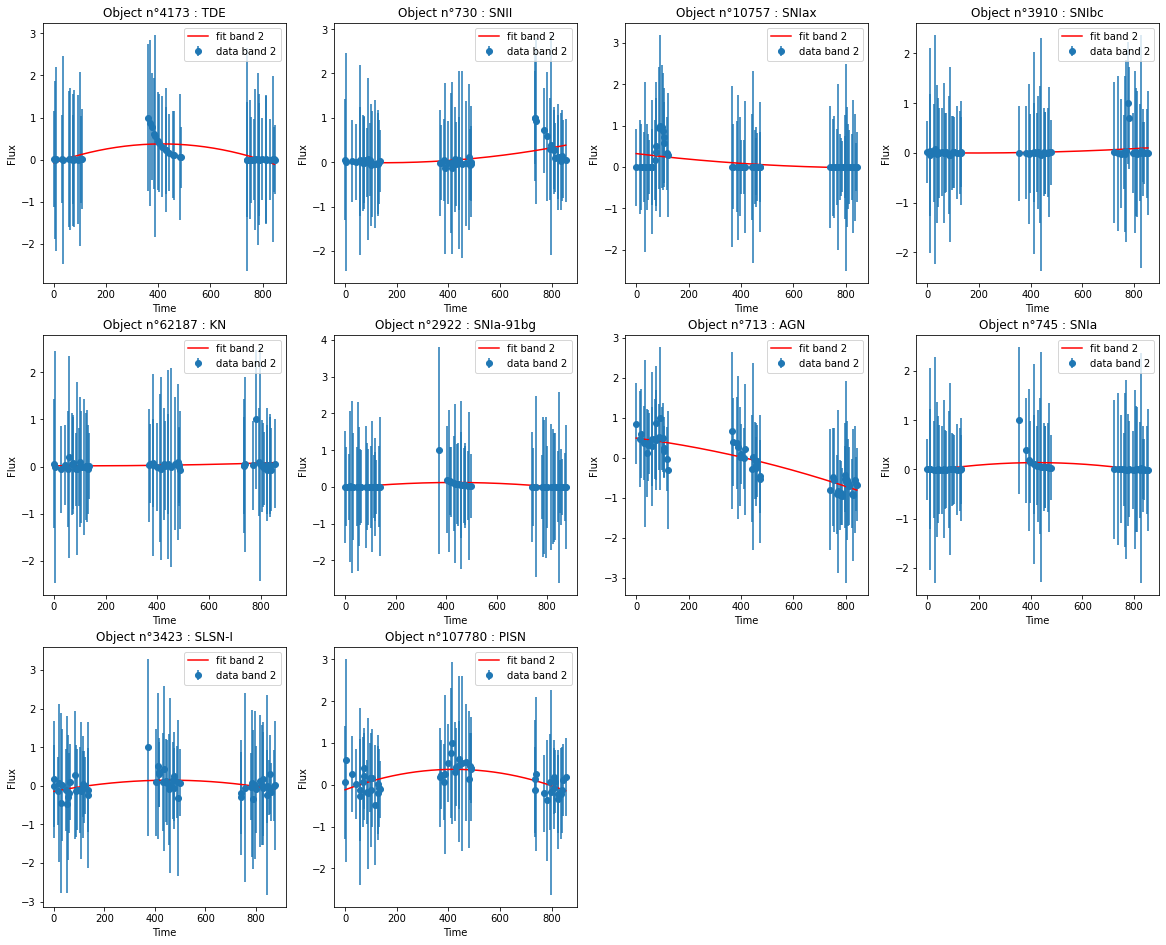

In [45]:
# Now let's use this function to see how well each object is fited

plt.figure(figsize=(20,22))
a=0

for i in target_types[0:len(target_types)-1]:
    a+=1
    j=0
    obj=objects[j]
    obj_target= get_target(obj)

    while (obj_target!=i) and (j!=len(objects)-1) :
        j+=1
        obj=objects[j]
        obj_target= np.array(data[data['object_id']==obj]['target'])[0]
  
    plt.subplot(4,4,a)
    compare(obj,2,param_table,pltmodel,nb_param,extra,band_used)

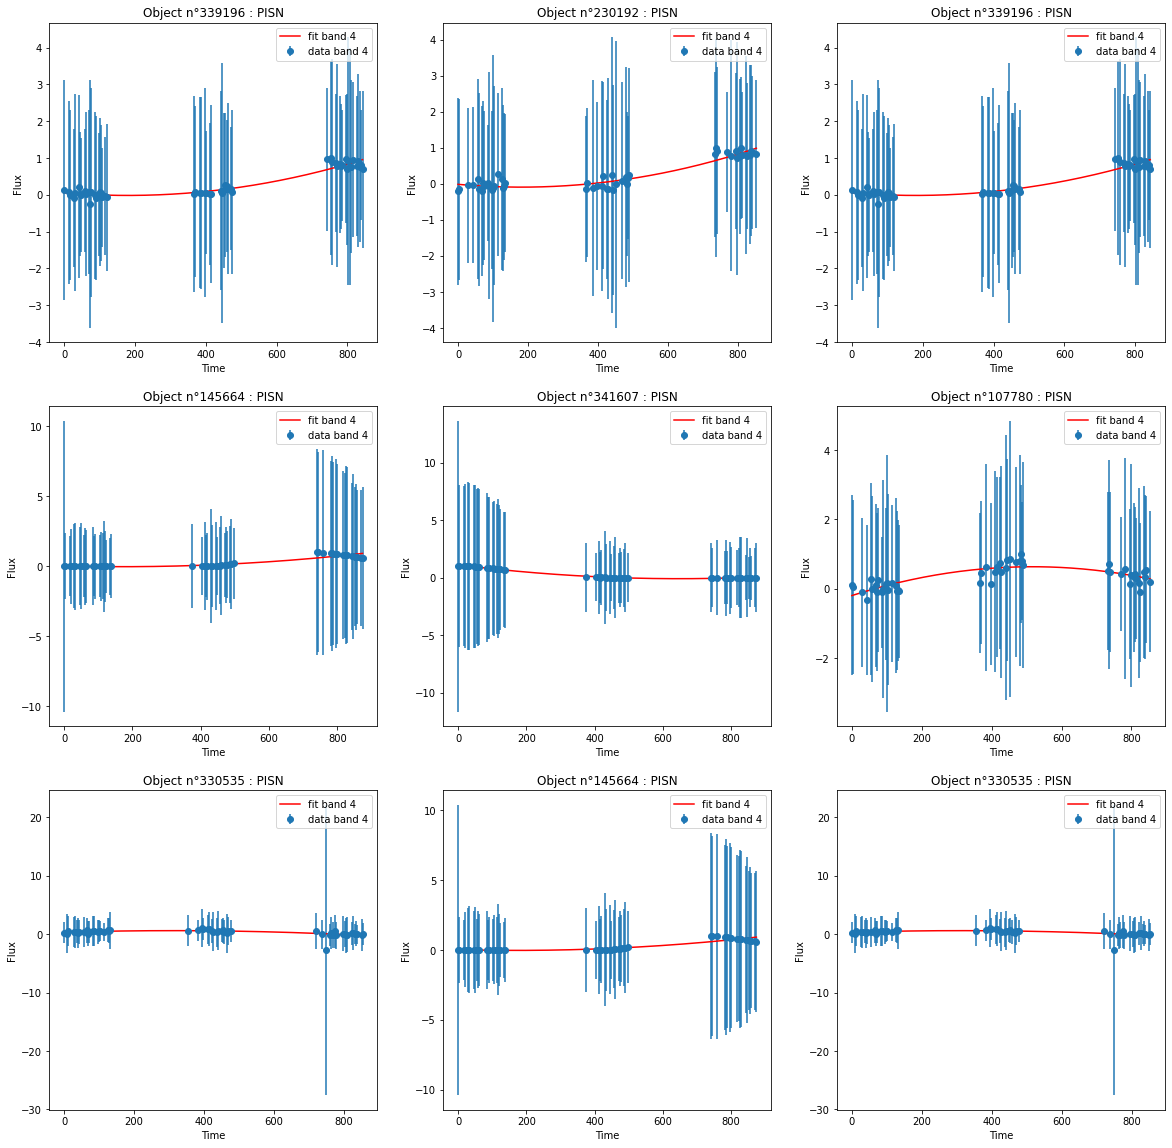

In [46]:
# Now let's use this function to see how well PISN are fitted
       
plt.figure(figsize=(20,20))
ids_type = np.unique(data.loc[data['target']==994,'object_id'])

for i in range(9):

    obj=np.random.choice(ids_type)
    obj_target= np.array(data[data['object_id']==obj]['target'])[0]
    plt.subplot(3,3,i+1)
    compare(obj,4,param_table,pltmodel,nb_param,extra,band_used)

Not enough points for object 230192 in band 0
Not enough points for object 230192 in band 1


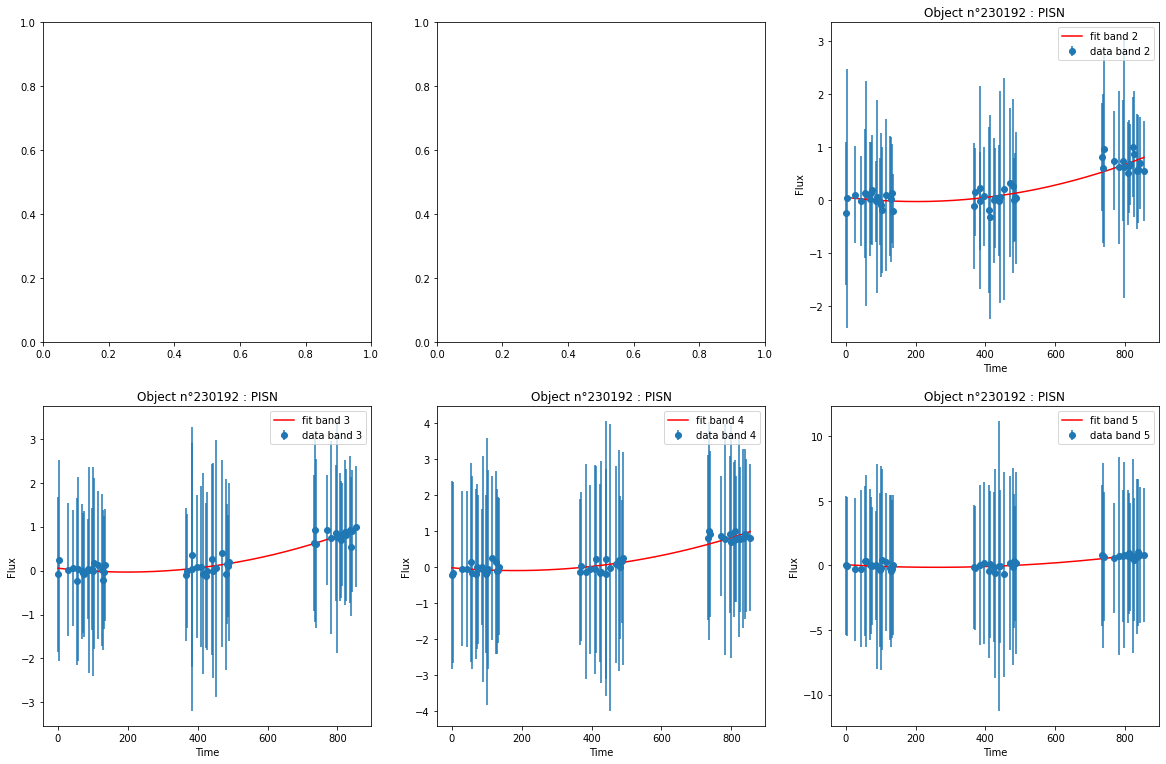

In [48]:
#For a specific PISN 

plt.figure(figsize=(20,20))
ids_type = np.unique(data.loc[data['target']==994,'object_id'])
obj=np.random.choice(ids_type)

for i in (0,1,2,3,4,5):

    obj_target= np.array(data[data['object_id']==obj]['target'])[0]
    plt.subplot(3,3,i+1)
    
    compare(obj,i,param_table,pltmodel,nb_param,extra,band_used)